In [18]:
import json
import pandas as pd
import os
from datetime import datetime
import matplotlib.pyplot as plt
import random
import tokenizer
import numpy as np
from multiprocessing import Pool
%matplotlib inline
import copy
import time
import scipy.stats

In [36]:
DATA_PATH = "./ALL_DATA_2/"
all_data_file_names = os.listdir(DATA_PATH)

In [19]:
record_numbers_df = pd.read_json("simulation_results.json")
record_numbers_df

,1,2,3,4,5,6,7,8,9,10,...,41,42,43,44,45,46,47,48,49,50
0,0.411622,0.647327,0.773213,0.850511,0.890420,0.918649,0.941892,0.952462,0.964204,0.973363,...,0.999489,0.999580,0.999550,0.999610,0.999610,0.999580,0.999550,0.999520,0.999489,0.999730
1,0.462643,0.659339,0.767988,0.846997,0.902763,0.929219,0.950541,0.963243,0.970661,0.977117,...,0.999640,0.999610,0.999520,0.999429,0.999429,0.999429,0.999429,0.999399,0.999399,0.999429
2,0.426486,0.661081,0.763844,0.839219,0.879970,0.914745,0.937868,0.950210,0.963724,0.970991,...,0.999610,0.999700,0.999700,0.999700,0.999700,0.999730,0.999790,0.999760,0.999730,0.999700
3,0.448589,0.630090,0.744805,0.828859,0.877417,0.914324,0.939339,0.950480,0.962072,0.973003,...,0.999580,0.999550,0.999550,0.999489,0.999670,0.999640,0.999640,0.999580,0.999700,0.999700
4,0.472583,0.687928,0.785976,0.852222,0.897718,0.922643,0.942673,0.954625,0.963033,0.970871,...,0.999369,0.999550,0.999459,0.999489,0.999520,0.999730,0.999760,0.999700,0.999640,0.999700
5,0.477718,0.662312,0.767387,0.833213,0.890120,0.917267,0.938228,0.951892,0.962072,0.968649,...,0.999039,0.998949,0.998889,0.998769,0.999129,0.999129,0.999099,0.999189,0.999159,0.999189
6,0.428769,0.635465,0.756156,0.821351,0.875676,0.903544,0.923634,0.943393,0.957748,0.967898,...,0.999670,0.999610,0.999700,0.999700,0.999700,0.999700,0.999700,0.999790,0.999760,0.999790
7,0.450871,0.655135,0.767117,0.835105,0.874414,0.907718,0.932553,0.951261,0.963183,0.972192,...,0.999099,0.999279,0.999429,0.999369,0.999369,0.999459,0.999369,0.999279,0.999580,0.999580
8,0.437237,0.657087,0.772342,0.847267,0.889640,0.918919,0.941381,0.956426,0.964715,0.973303,...,0.999670,0.999700,0.999640,0.999640,0.999580,0.999580,0.999580,0.999520,0.999459,0.999429
9,0.414985,0.626126,0.745405,0.829129,0.886877,0.912312,0.937057,0.951051,0.965165,0.972643,...,0.999249,0.999279,0.999279,0.999399,0.999399,0.999459,0.999429,0.999399,0.999429,0.999640


In [20]:
means = record_numbers_df.mean(axis=0)
stds = record_numbers_df.std(axis=0)
stats_of_experiment = pd.DataFrame({'mean': means, "std": stds}).transpose()
stats_of_experiment

,1,2,3,4,5,6,7,8,9,10,...,41,42,43,44,45,46,47,48,49,50
mean,0.444053,0.647345,0.763377,0.837060,0.884213,0.914806,0.937529,0.952752,0.963592,0.972009,...,0.999377,0.999407,0.999396,0.999398,0.999440,0.999441,0.999455,0.999492,0.999536,0.999537
std,0.022294,0.017453,0.015197,0.011546,0.010507,0.007723,0.007179,0.005253,0.003513,0.002569,...,0.000203,0.000201,0.000208,0.000216,0.000178,0.000199,0.000218,0.000212,0.000198,0.000173


In [21]:
stats_of_experiment_copy = stats_of_experiment.T
stats_of_experiment_copy[stats_of_experiment_copy['mean'] >= 0.96]


,mean,std
9,0.963592,0.003513
10,0.972009,0.002569
11,0.978194,0.001903
12,0.982815,0.002107
13,0.985928,0.001915
14,0.988338,0.001531
15,0.990288,0.001178
16,0.991895,0.000925
17,0.993203,0.000794
18,0.994032,0.000916


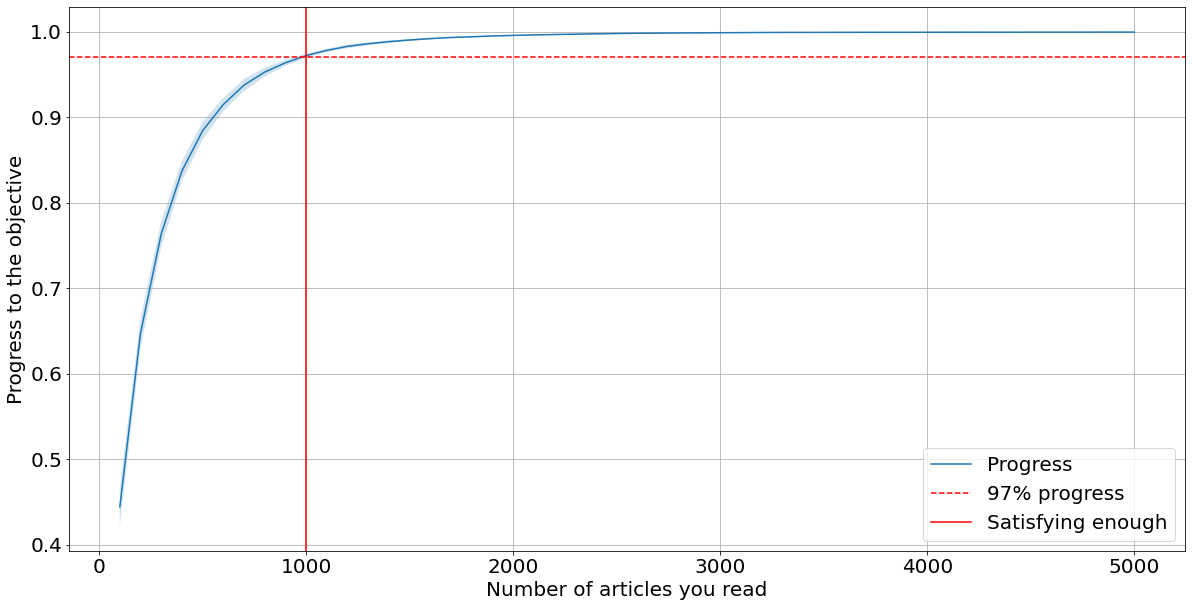

In [22]:
plt.rc('font', size=20) #controls default text size
plt.figure(figsize=(20, 10))
plt.plot(stats_of_experiment.columns * 100, stats_of_experiment.loc['mean'], label='Progress')
plt.fill_between(record_numbers_df.columns * 100, stats_of_experiment.loc['mean'] - stats_of_experiment.loc['std'], stats_of_experiment.loc['mean'] + stats_of_experiment.loc['std'], alpha=0.2)
plt.axhline(0.97, color='r', linestyle='--', label='97% progress')
plt.axvline(1000, color='r', linestyle='-', label='Satisfying enough')
plt.xlabel("Number of articles you read", fontdict={'size': 20})
plt.ylabel("Progress to the objective", fontdict={'size': 20})
plt.grid(True)
plt.legend()
plt.savefig("something.png")

# If you only better?

## Article Selection
If the articles are selected carefully. can we actually reduce this number?
Sample a random 100 articles. Select the article that maximizes the outcome. Keep repeating that till you reach 5000 articles.

How to select the optimal article? Seqentially
1. For each article, measure the change in the objective.
2. If the change is larger than before, keep it

In [23]:
record_items = []
record_items_meta = []
for i in range(40):
    with open(f"heavy_exp_results_{i}.json", "r") as file_handle:
        file_data = json.load(file_handle)
        record_items.append(file_data[0])        
        record_items_meta.append(file_data[1])

In [24]:
record_items_df = pd.DataFrame.from_records(record_items)
record_items_df

,1,2,3,4,5
0,0.787177,0.955045,0.992823,0.99997,1.00000
1,0.785706,0.952823,0.992793,0.99982,0.99994
2,0.780661,0.946066,0.991441,0.99991,1.00000
3,0.781742,0.950841,0.991772,0.99991,1.00000
4,0.799670,0.950120,0.992583,0.99997,1.00000
5,0.793303,0.948138,0.992823,1.00000,NaN
6,0.773754,0.944384,0.991592,0.99982,1.00000
7,0.785856,0.948709,0.989820,0.99970,0.99997
8,0.833874,0.967087,0.995976,0.99991,1.00000
9,0.785976,0.947267,0.990571,0.99976,1.00000


In [25]:
means_2 = record_items_df.mean(axis=0)
stds_2 = record_items_df.std(axis=0)
stats_of_experiment_2 = pd.DataFrame({'mean': means_2, "std": stds_2}).transpose()
stats_of_experiment_2.columns = stats_of_experiment_2.columns.astype(int)
stats_of_experiment_2

,1,2,3,4,5
mean,0.791485,0.951081,0.992372,0.999893,0.999997
std,0.014697,0.005548,0.001564,0.000088,0.000012


In [26]:
stats_of_experiment_2.columns

Int64Index([1, 2, 3, 4, 5], dtype='int64')

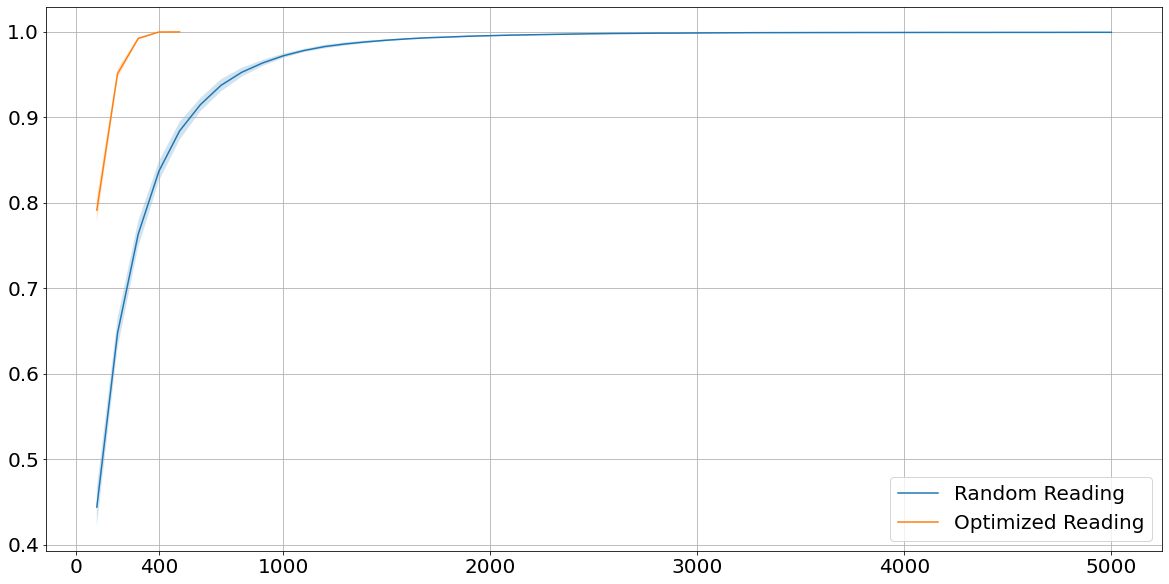

In [27]:
plt.figure(figsize=(20, 10))
plt.rc('font', size=20) #controls default text size
plt.plot(stats_of_experiment.columns * 100, stats_of_experiment.loc['mean'], label='Random Reading')
plt.plot(stats_of_experiment_2.columns * 100, stats_of_experiment_2.loc['mean'], label='Optimized Reading')

plt.fill_between(record_numbers_df.columns * 100, stats_of_experiment.loc['mean'] - stats_of_experiment.loc['std'], stats_of_experiment.loc['mean'] + stats_of_experiment.loc['std'], alpha=0.2)
plt.fill_between(stats_of_experiment_2.columns * 100, stats_of_experiment_2.loc['mean'] - stats_of_experiment_2.loc['std'], stats_of_experiment_2.loc['mean'] + stats_of_experiment_2.loc['std'], alpha=0.2)

# plt.axhline(0.97, color='r', linestyle='--', label='97% progress')
# plt.axvline(2000, color='r', linestyle='-', label='Satisfying enough - Random Reading')

# plt.axhline(0.97, color='g', linestyle='--', label='97% progress')
# plt.axvline(250, color='g', linestyle='-',
            # label='Satisfying enough - Optimized Reading')
# plt.xlabel("Number of articles you read", fontdict={'size': 20})
# plt.ylabel("Progress to the objective", fontdict={'size': 20})
plt.xticks(ticks=[0, 400, 1000, 2000, 3000, 4000, 5000])
plt.grid(True)
plt.legend()
plt.savefig("something_2.png")

# Analysis of the topics/dates in the optimized data

In [28]:
record_items_meta_year = {}
for trial_index, trial_data in enumerate(record_items_meta):
    record_items_meta_year[trial_index] = {}
    for trial_data_keys in trial_data:
        # print(trial_data[trial_data_keys])
        for date in trial_data[trial_data_keys]['date']:
            year = int(date['year'])
            try:
                record_items_meta_year[trial_index][year] += 1
            except:
                record_items_meta_year[trial_index][year] = 1

In [29]:
record_items_meta_year_df = pd.DataFrame.from_records(record_items_meta_year)
record_items_meta_year_df.sort_index(inplace=True)
# record_items_meta_year_df[0].hist(grid=True, figsize=(15, 10))
# record_items_meta_year_df.plot.bar(figsize=(15, 10))
record_items_meta_year_df = 100 * record_items_meta_year_df / record_items_meta_year_df.sum(
    axis=0)
record_items_meta_year_df

,0,1,2,3,4,5,6,7,8,9,...,30,31,32,33,34,35,36,37,38,39
2000,3.8,6.0,3.8,5.6,4.0,3.75,5.8,5.2,4.6,3.4,...,4.25,4.2,4.8,3.50,3.0,5.25,5.0,4.50,5.4,3.8
2001,8.6,6.6,9.2,9.6,6.0,8.75,11.0,6.4,8.2,9.2,...,7.75,11.0,7.6,9.75,9.2,7.50,7.8,7.50,7.8,10.0
2002,7.0,7.4,7.2,4.4,6.6,8.00,5.4,10.0,6.8,7.2,...,7.75,7.0,3.8,4.50,9.2,5.50,5.2,7.00,5.6,5.6
2003,4.4,3.6,6.2,3.2,3.8,4.50,4.8,4.0,3.4,5.4,...,3.25,4.6,3.4,4.00,4.6,3.25,3.6,5.50,3.4,3.4
2004,4.6,3.2,3.8,3.6,3.6,3.25,3.4,4.0,3.2,4.2,...,6.00,4.0,5.0,4.00,4.2,2.25,5.2,3.00,4.4,2.6
2005,3.6,3.2,3.8,4.0,5.4,2.75,2.6,3.4,4.2,3.0,...,4.50,3.4,2.6,1.75,2.2,3.50,2.4,3.00,4.8,2.8
2006,2.6,3.0,3.0,2.4,2.4,2.25,2.0,1.4,1.6,2.2,...,4.00,2.4,2.8,2.50,3.4,2.50,3.8,3.50,4.0,1.2
2007,2.0,2.8,1.6,2.4,3.4,1.50,2.6,1.6,4.2,1.6,...,3.25,2.2,2.6,3.00,2.8,3.50,2.8,3.75,2.6,3.0
2008,2.4,2.8,3.2,3.2,2.8,2.75,1.8,2.2,3.0,4.2,...,1.50,2.8,2.0,1.50,3.2,1.25,2.0,1.25,3.0,3.2
2009,2.4,2.8,2.0,1.8,2.4,2.25,1.4,2.6,2.8,2.4,...,3.25,2.4,2.0,2.00,1.8,1.50,3.6,3.50,3.2,3.0


In [30]:
record_items_meta_year_df_summary = {'mean': record_items_meta_year_df.T.mean(), 'std': record_items_meta_year_df.T.std()}
record_items_meta_year_df_summary = pd.DataFrame.from_dict(record_items_meta_year_df_summary)
record_items_meta_year_df_summary

,mean,std
2000,4.51125,0.889936
2001,8.38625,1.290348
2002,6.43250,1.464037
2003,4.22750,0.842459
2004,4.02750,0.875445
2005,3.38375,0.852477
2006,2.61625,0.830538
2007,2.65750,0.751797
2008,2.70250,0.779953
2009,2.44500,0.741343


In [31]:
record_items_meta_year_df_summary.sum()

mean    100.000000
std      22.215222
dtype: float64

<AxesSubplot:>

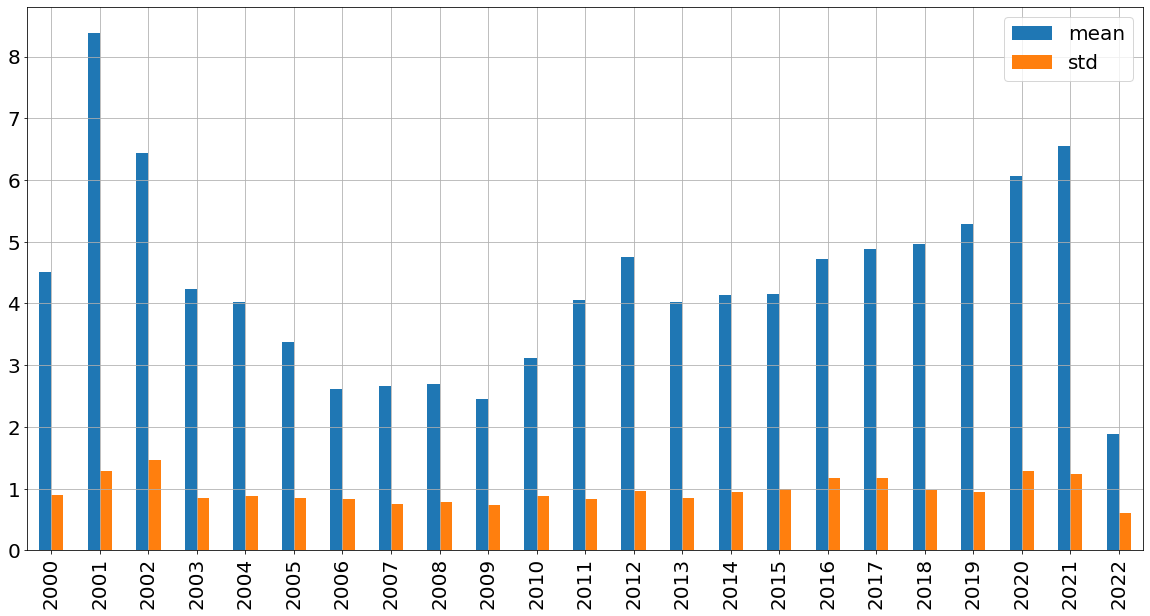

In [47]:
record_items_meta_year_df_summary.plot.bar(figsize=(20, 10), grid=True)

## What is the natural distribution of the years look like?

In [49]:
normal_years_distribtion = {}
for demo_trial in range(40):
    normal_years_distribtion[demo_trial] = {}
    for i in range(5):
        sample_article_filenames = random.choices(all_data_file_names, k=100)
        for single_article_filename in sample_article_filenames:
            with open(DATA_PATH + single_article_filename, 'r') as file_handle:
                article_content = json.load(file_handle)
                year = int(article_content['publication_date']['year'])
                try:
                    normal_years_distribtion[demo_trial][year] += 1
                except:
                    normal_years_distribtion[demo_trial][year] = 1

normal_years_distribtion

{0: {2002: 34,
  2010: 29,
  2014: 21,
  2001: 50,
  2020: 15,
  2008: 23,
  2012: 24,
  2007: 25,
  2003: 18,
  2000: 27,
  2019: 13,
  2013: 18,
  2004: 18,
  2011: 23,
  2021: 29,
  2006: 17,
  2015: 15,
  2005: 23,
  2018: 15,
  2017: 13,
  2009: 22,
  2016: 21,
  2022: 7},
 1: {2020: 17,
  2007: 30,
  2004: 21,
  2017: 22,
  2000: 19,
  2002: 38,
  2015: 13,
  2016: 24,
  2005: 20,
  2006: 20,
  2021: 10,
  2008: 33,
  2010: 26,
  2018: 24,
  2001: 34,
  2003: 12,
  2014: 12,
  2013: 28,
  2012: 24,
  2011: 28,
  2009: 29,
  2019: 13,
  2022: 3},
 2: {2008: 24,
  2018: 14,
  2006: 17,
  2003: 30,
  2009: 24,
  2012: 24,
  2011: 31,
  2015: 28,
  2001: 34,
  2000: 23,
  2002: 33,
  2014: 16,
  2020: 15,
  2007: 28,
  2016: 20,
  2017: 22,
  2004: 23,
  2005: 15,
  2010: 30,
  2022: 4,
  2013: 24,
  2019: 5,
  2021: 16},
 3: {2009: 27,
  2001: 38,
  2010: 31,
  2016: 21,
  2000: 28,
  2007: 27,
  2011: 22,
  2002: 33,
  2003: 22,
  2020: 19,
  2017: 20,
  2021: 10,
  2015: 21,
  201

In [50]:
# normal_years_distribtion_df = {'year': list(normal_years_distribtion.keys()), 'frequency': list(normal_years_distribtion.values())}
normal_years_distribtion_df = pd.DataFrame.from_dict(normal_years_distribtion)
# normal_years_distribtion_df.set_index(normal_years_distribtion_df['year'], inplace=True)
# normal_years_distribtion_df.drop(columns=['year'], inplace=True)
normal_years_distribtion_df.sort_index(inplace=True)
normal_years_distribtion_df.fillna(0, inplace=True)
# normal_years_distribtion_df.plot.bar(figsize=(20, 10))
normal_years_distribtion_df = 100 * normal_years_distribtion_df / \
    normal_years_distribtion_df.sum(axis=0)
normal_years_distribtion_df
# normal_years_distribtion_df


,0,1,2,3,4,5,6,7,8,9,...,30,31,32,33,34,35,36,37,38,39
2000,5.4,3.8,4.6,5.6,4.8,4.6,6.0,6.0,6.6,6.4,...,5.0,6.2,4.6,7.2,5.2,6.4,4.8,6.2,6.2,5.4
2001,10.0,6.8,6.8,7.6,10.4,8.4,11.4,10.8,10.0,6.8,...,7.8,8.0,9.0,11.6,9.2,11.2,7.0,7.0,9.2,8.2
2002,6.8,7.6,6.6,6.6,6.0,6.2,6.2,7.2,7.2,5.4,...,8.0,6.4,6.0,6.0,7.2,5.0,6.6,9.4,6.2,6.6
2003,3.6,2.4,6.0,4.4,5.0,6.2,3.2,3.8,4.6,3.8,...,4.6,3.2,3.0,3.8,6.8,3.4,4.6,3.6,4.0,4.6
2004,3.6,4.2,4.6,3.0,4.6,3.4,4.8,3.8,4.4,3.6,...,3.8,1.8,4.0,4.6,3.6,4.0,4.0,4.4,3.6,3.6
2005,4.6,4.0,3.0,4.2,4.4,3.2,2.8,4.0,2.2,6.6,...,4.6,4.6,4.6,3.6,5.6,5.2,5.8,3.2,4.2,5.6
2006,3.4,4.0,3.4,3.0,4.4,3.8,3.0,3.2,4.2,4.2,...,6.2,6.2,4.8,4.2,2.0,3.2,5.0,5.2,4.4,6.0
2007,5.0,6.0,5.6,5.4,3.4,4.2,4.2,4.2,4.6,5.2,...,4.2,3.4,4.8,3.2,4.4,3.6,4.4,4.2,3.4,4.8
2008,4.6,6.6,4.8,4.8,5.6,3.6,4.6,4.0,3.2,4.8,...,4.2,5.0,6.6,2.6,4.6,3.8,4.8,3.8,4.8,5.0
2009,4.4,5.8,4.8,5.4,4.2,6.0,5.6,4.2,3.8,5.0,...,3.2,4.6,4.2,5.0,4.4,4.0,3.6,4.4,7.4,4.0


In [51]:
normal_years_distribtion_df_summary = {'mean': normal_years_distribtion_df.T.mean(), 'std': normal_years_distribtion_df.T.std()}
normal_years_distribtion_df_summary = pd.DataFrame.from_dict(normal_years_distribtion_df_summary)
normal_years_distribtion_df_summary

,mean,std
2000,5.615,0.941780
2001,8.685,1.381851
2002,6.470,0.985588
2003,4.190,0.971333
2004,3.920,0.721537
2005,4.355,0.984482
2006,4.005,0.984482
2007,4.425,0.887737
2008,4.355,0.979259
2009,4.610,0.953213


<Figure size 432x288 with 0 Axes>

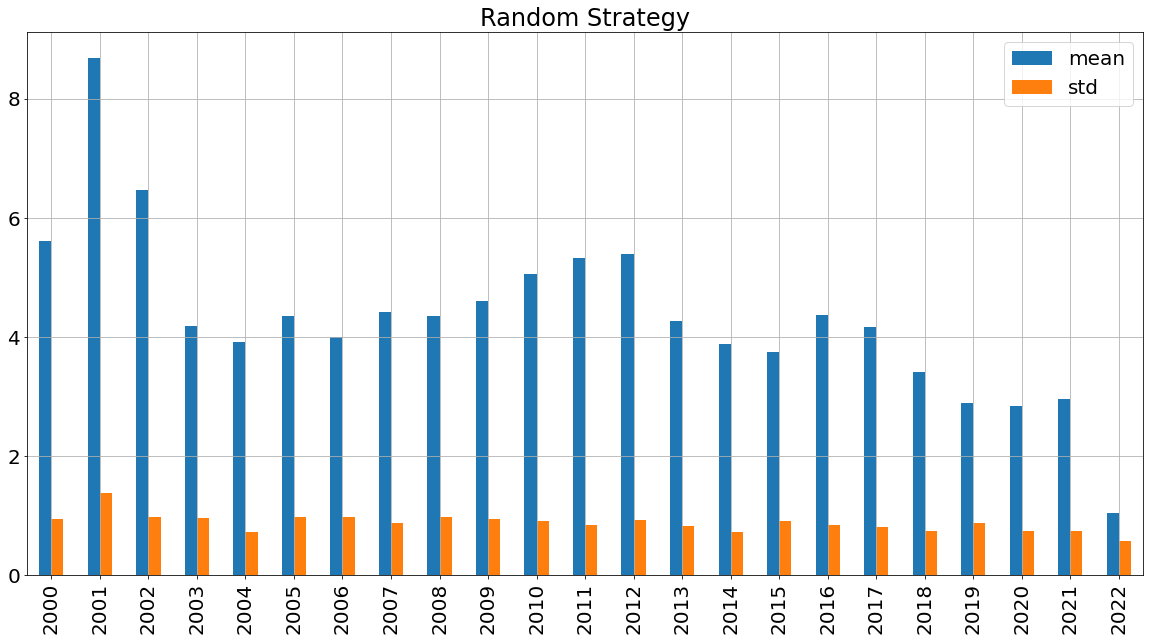

<Figure size 432x288 with 0 Axes>

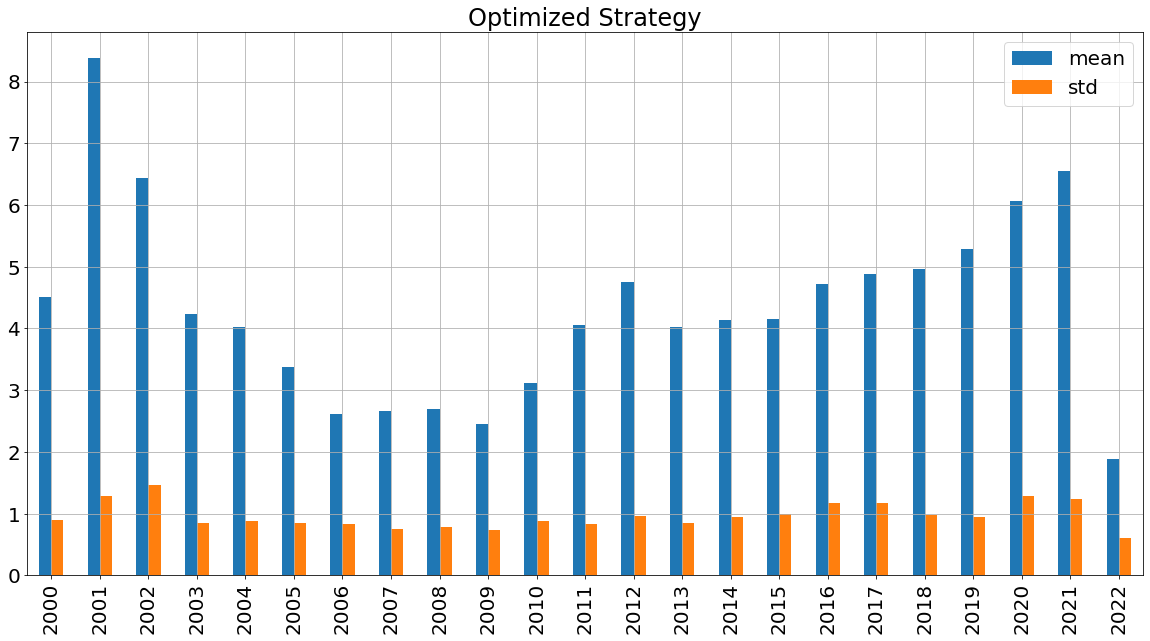

In [52]:
plt.figure()
normal_years_distribtion_df_summary.plot.bar(figsize=(20, 10), grid=True)
plt.title("Random Strategy")
plt.savefig('random_years_distribution.png')
plt.figure()
record_items_meta_year_df_summary.plot.bar(figsize=(20, 10), grid=True)
plt.title("Optimized Strategy")
plt.savefig('optimized_years_distribution.png')


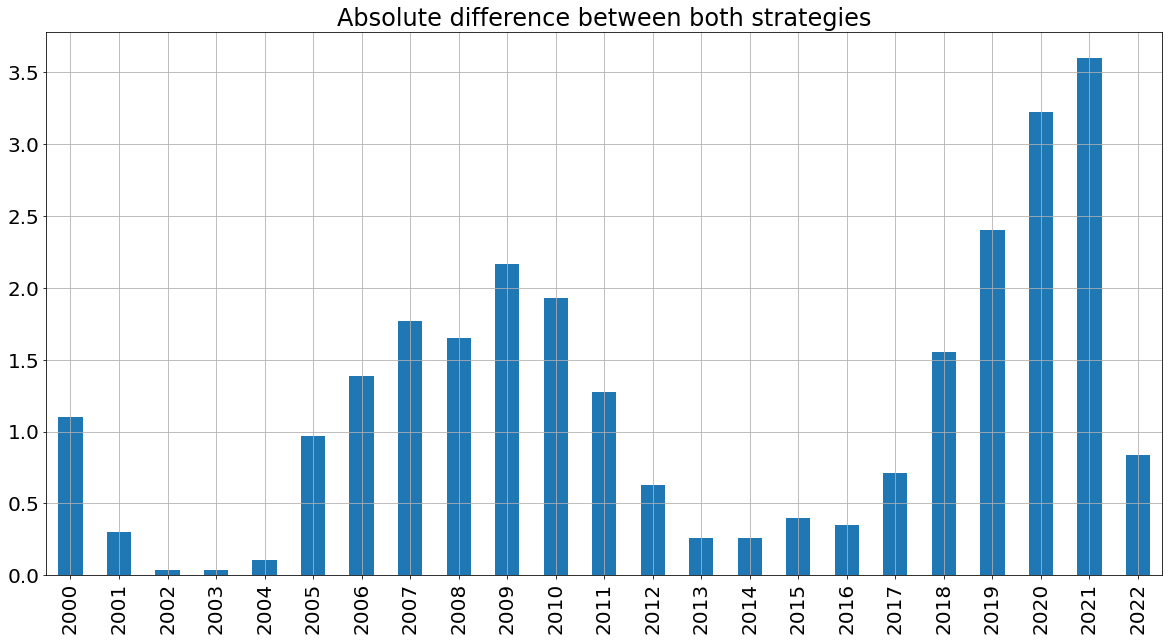

In [53]:
x = np.abs(normal_years_distribtion_df_summary - record_items_meta_year_df_summary)
# x = normal_years_distribtion_df_summary - record_items_meta_year_df_summary

plt.figure()
x['mean'].plot.bar(figsize=(20, 10), grid=True)
plt.title('Absolute difference between both strategies')
plt.savefig('years_absolute_difference.png')

In [54]:
normal_years_distribtion_df
# record_items_meta_year_df

,0,1,2,3,4,5,6,7,8,9,...,30,31,32,33,34,35,36,37,38,39
2000,5.4,3.8,4.6,5.6,4.8,4.6,6.0,6.0,6.6,6.4,...,5.0,6.2,4.6,7.2,5.2,6.4,4.8,6.2,6.2,5.4
2001,10.0,6.8,6.8,7.6,10.4,8.4,11.4,10.8,10.0,6.8,...,7.8,8.0,9.0,11.6,9.2,11.2,7.0,7.0,9.2,8.2
2002,6.8,7.6,6.6,6.6,6.0,6.2,6.2,7.2,7.2,5.4,...,8.0,6.4,6.0,6.0,7.2,5.0,6.6,9.4,6.2,6.6
2003,3.6,2.4,6.0,4.4,5.0,6.2,3.2,3.8,4.6,3.8,...,4.6,3.2,3.0,3.8,6.8,3.4,4.6,3.6,4.0,4.6
2004,3.6,4.2,4.6,3.0,4.6,3.4,4.8,3.8,4.4,3.6,...,3.8,1.8,4.0,4.6,3.6,4.0,4.0,4.4,3.6,3.6
2005,4.6,4.0,3.0,4.2,4.4,3.2,2.8,4.0,2.2,6.6,...,4.6,4.6,4.6,3.6,5.6,5.2,5.8,3.2,4.2,5.6
2006,3.4,4.0,3.4,3.0,4.4,3.8,3.0,3.2,4.2,4.2,...,6.2,6.2,4.8,4.2,2.0,3.2,5.0,5.2,4.4,6.0
2007,5.0,6.0,5.6,5.4,3.4,4.2,4.2,4.2,4.6,5.2,...,4.2,3.4,4.8,3.2,4.4,3.6,4.4,4.2,3.4,4.8
2008,4.6,6.6,4.8,4.8,5.6,3.6,4.6,4.0,3.2,4.8,...,4.2,5.0,6.6,2.6,4.6,3.8,4.8,3.8,4.8,5.0
2009,4.4,5.8,4.8,5.4,4.2,6.0,5.6,4.2,3.8,5.0,...,3.2,4.6,4.2,5.0,4.4,4.0,3.6,4.4,7.4,4.0


In [55]:
record_items_meta_year_df

,0,1,2,3,4,5,6,7,8,9,...,30,31,32,33,34,35,36,37,38,39
2000,3.8,6.0,3.8,5.6,4.0,3.75,5.8,5.2,4.6,3.4,...,4.25,4.2,4.8,3.50,3.0,5.25,5.0,4.50,5.4,3.8
2001,8.6,6.6,9.2,9.6,6.0,8.75,11.0,6.4,8.2,9.2,...,7.75,11.0,7.6,9.75,9.2,7.50,7.8,7.50,7.8,10.0
2002,7.0,7.4,7.2,4.4,6.6,8.00,5.4,10.0,6.8,7.2,...,7.75,7.0,3.8,4.50,9.2,5.50,5.2,7.00,5.6,5.6
2003,4.4,3.6,6.2,3.2,3.8,4.50,4.8,4.0,3.4,5.4,...,3.25,4.6,3.4,4.00,4.6,3.25,3.6,5.50,3.4,3.4
2004,4.6,3.2,3.8,3.6,3.6,3.25,3.4,4.0,3.2,4.2,...,6.00,4.0,5.0,4.00,4.2,2.25,5.2,3.00,4.4,2.6
2005,3.6,3.2,3.8,4.0,5.4,2.75,2.6,3.4,4.2,3.0,...,4.50,3.4,2.6,1.75,2.2,3.50,2.4,3.00,4.8,2.8
2006,2.6,3.0,3.0,2.4,2.4,2.25,2.0,1.4,1.6,2.2,...,4.00,2.4,2.8,2.50,3.4,2.50,3.8,3.50,4.0,1.2
2007,2.0,2.8,1.6,2.4,3.4,1.50,2.6,1.6,4.2,1.6,...,3.25,2.2,2.6,3.00,2.8,3.50,2.8,3.75,2.6,3.0
2008,2.4,2.8,3.2,3.2,2.8,2.75,1.8,2.2,3.0,4.2,...,1.50,2.8,2.0,1.50,3.2,1.25,2.0,1.25,3.0,3.2
2009,2.4,2.8,2.0,1.8,2.4,2.25,1.4,2.6,2.8,2.4,...,3.25,2.4,2.0,2.00,1.8,1.50,3.6,3.50,3.2,3.0


In [57]:
normal_years_distribtion_df_t = normal_years_distribtion_df.T
record_items_meta_year_df_t = record_items_meta_year_df.T

years_signficance = {}
for year in normal_years_distribtion_df_t.columns:
    significance = scipy.stats.wilcoxon(
        normal_years_distribtion_df_t[year], record_items_meta_year_df_t[year])

    years_signficance[year] = {
        'p-value': significance.pvalue
    }

    # significance_t_test = scipy.stats.ttest_ind(
    #     normal_years_distribtion_df_t[year], record_items_meta_year_df_t[year])
    if significance.pvalue < 0.05:
        print(f"{year} :: {significance}")
        years_signficance[year]['is_significant'] = True
    else:
        years_signficance[year]['is_significant'] = False

pd.DataFrame.from_dict(years_signficance).to_csv('years_signficance.csv')

print(list(years_signficance.keys()))

2000 :: WilcoxonResult(statistic=90.0, pvalue=4.7180458484793146e-05)
2005 :: WilcoxonResult(statistic=132.5, pvalue=0.00032544516187494774)
2006 :: WilcoxonResult(statistic=55.0, pvalue=1.8066956352920226e-06)
2007 :: WilcoxonResult(statistic=2.5, pvalue=6.372442982968082e-08)
2008 :: WilcoxonResult(statistic=20.5, pvalue=1.6379970701704073e-07)
2009 :: WilcoxonResult(statistic=3.0, pvalue=6.62297475389244e-08)
2010 :: WilcoxonResult(statistic=5.0, pvalue=5.187216575563647e-08)
2011 :: WilcoxonResult(statistic=56.0, pvalue=3.104961723847069e-06)
2012 :: WilcoxonResult(statistic=192.5, pvalue=0.009800285377052412)
2017 :: WilcoxonResult(statistic=189.0, pvalue=0.005017454942150342)
2018 :: WilcoxonResult(statistic=6.0, pvalue=8.32409025816452e-08)
2019 :: WilcoxonResult(statistic=10.0, pvalue=7.540389538362267e-08)
2020 :: WilcoxonResult(statistic=0.0, pvalue=3.558045309144898e-08)
2021 :: WilcoxonResult(statistic=2.0, pvalue=4.126511515569068e-08)
2022 :: WilcoxonResult(statistic=49.5

# Let's take a look at the topic differences

In [58]:
normal_topics_distribtion = {}
for demo_trial in range(40):
    normal_topics_distribtion[demo_trial] = {}
    for i in range(5):
        sample_article_filenames = random.choices(all_data_file_names, k=100)
        for single_article_filename in sample_article_filenames:
            with open(DATA_PATH + single_article_filename, 'r') as file_handle:
                article_content = json.load(file_handle)
                # print(list(article_content.keys()))
                topic = article_content['topic_category']
                try:
                    normal_topics_distribtion[demo_trial][topic] += 1
                except:
                    normal_topics_distribtion[demo_trial][topic] = 1

normal_topics_distribtion_df = pd.DataFrame.from_dict(
    normal_topics_distribtion).fillna(0)
normal_topics_distribtion_df


,0,1,2,3,4,5,6,7,8,9,...,30,31,32,33,34,35,36,37,38,39
pixels,3.0,5.0,5.0,4.0,0.0,5.0,1.0,6.0,1.0,6.0,...,3.0,5.0,1.0,7.0,3.0,2.0,1.0,4.0,4.0,3.0
international,14.0,15.0,17.0,21.0,12.0,25.0,16.0,11.0,22.0,15.0,...,14.0,16.0,15.0,25.0,18.0,12.0,28.0,16.0,24.0,17.0
archives,152.0,139.0,167.0,151.0,162.0,144.0,142.0,153.0,157.0,145.0,...,129.0,154.0,153.0,173.0,148.0,155.0,128.0,160.0,119.0,133.0
argent,2.0,4.0,0.0,0.0,2.0,2.0,1.0,1.0,3.0,1.0,...,4.0,1.0,3.0,3.0,0.0,2.0,2.0,0.0,1.0,2.0
vous,18.0,11.0,9.0,8.0,8.0,15.0,16.0,13.0,21.0,9.0,...,12.0,16.0,12.0,13.0,13.0,8.0,11.0,3.0,12.0,11.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
series,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
ete,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
onatousbesoindusud,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
blog-du-tour-de-france,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [59]:
record_items_meta_topics = {}
for trial_index, trial_data in enumerate(record_items_meta):
    record_items_meta_topics[trial_index] = {}
    for trial_data_keys in trial_data:
        # print(trial_data[trial_data_keys])
        for topic_item in trial_data[trial_data_keys]['topic']:
            # print(topic_item)
            # topic = topic_item['topic']
            try:
                record_items_meta_topics[trial_index][topic_item] += 1
            except:
                record_items_meta_topics[trial_index][topic_item] = 1
record_items_meta_topics_df = pd.DataFrame.from_dict(record_items_meta_topics).fillna(0)
record_items_meta_topics_df


,0,1,2,3,4,5,6,7,8,9,...,30,31,32,33,34,35,36,37,38,39
orientation-scolaire,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
archives,142.0,131.0,148.0,135.0,130.0,116.0,152.0,147.0,130.0,146.0,...,119.0,150.0,120.0,103.0,154.0,97.0,132.0,113.0,136.0,128.0
disparitions,3.0,3.0,8.0,0.0,6.0,1.0,4.0,6.0,4.0,4.0,...,4.0,4.0,3.0,1.0,3.0,5.0,4.0,2.0,6.0,4.0
m-actu,6.0,4.0,11.0,5.0,7.0,6.0,3.0,8.0,4.0,1.0,...,3.0,5.0,2.0,3.0,4.0,7.0,5.0,1.0,2.0,8.0
livres,13.0,6.0,6.0,11.0,8.0,9.0,9.0,7.0,7.0,6.0,...,5.0,6.0,4.0,3.0,11.0,5.0,8.0,8.0,9.0,7.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
festival-d-avignon,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
les-nouveaux-arrivants,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
partenaires,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
l-europe-a-l-heure-de-la-presidence-francaise,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


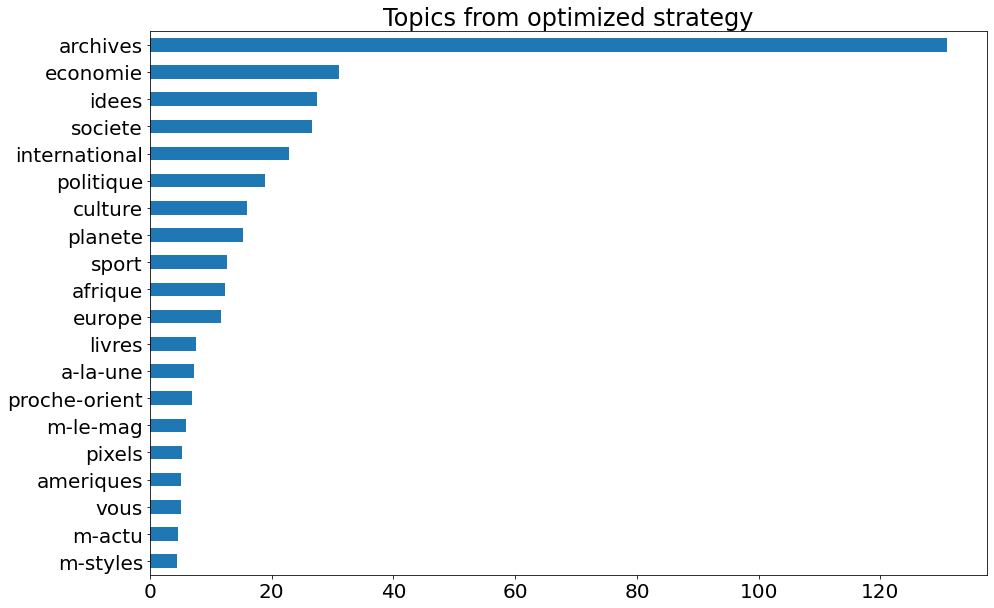

In [60]:
record_items_meta_topics_df_means = record_items_meta_topics_df.mean(
    axis=1).sort_values(ascending=True)
record_items_meta_topics_df_top_20 = record_items_meta_topics_df_means.iloc[-20:]
plt.figure()
record_items_meta_topics_df_top_20.plot.barh(figsize=(15, 10))
plt.title("Topics from optimized strategy")
plt.savefig('topics_optimized_strategy.png')

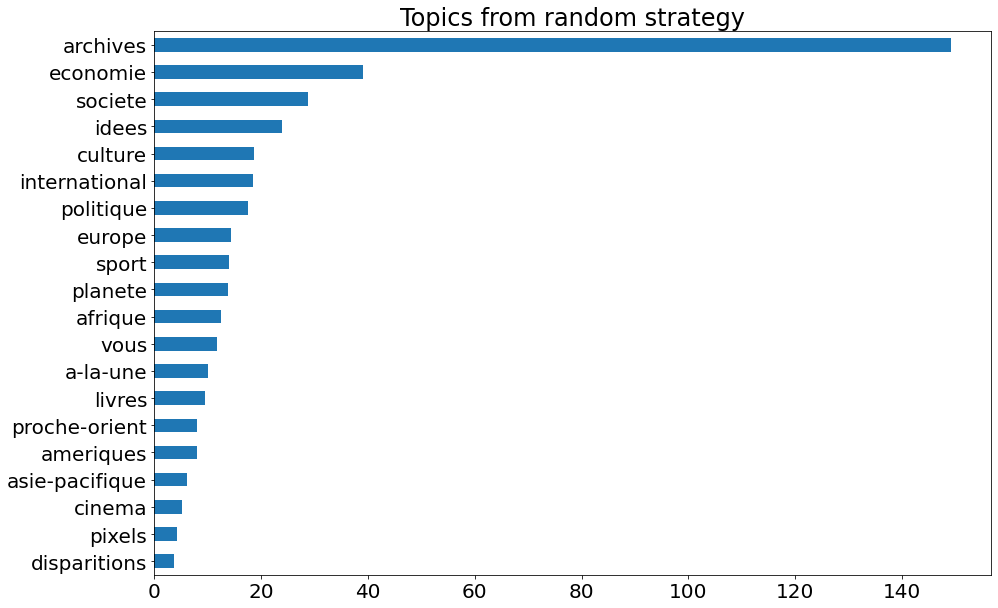

In [61]:
normal_topics_distribtion_df_means = normal_topics_distribtion_df.mean(
    axis=1).sort_values(ascending=True)
normal_topics_distribtion_df_top_20 = normal_topics_distribtion_df_means.iloc[-20:]
plt.figure()
normal_topics_distribtion_df_top_20.plot.barh(figsize=(15, 10))
plt.title("Topics from random strategy")
plt.savefig('topics_random_strategy.png')

,optimized,random
actualite-medias,0.000,0.650
technologies,0.000,0.705
disparitions,0.645,0.750
cinema,0.665,1.035
les-decodeurs,0.755,0.650
asie-pacifique,0.820,1.225
sciences,0.825,0.620
m-styles,0.900,0.710
m-actu,0.935,0.000
vous,1.015,2.365


<Figure size 432x288 with 0 Axes>

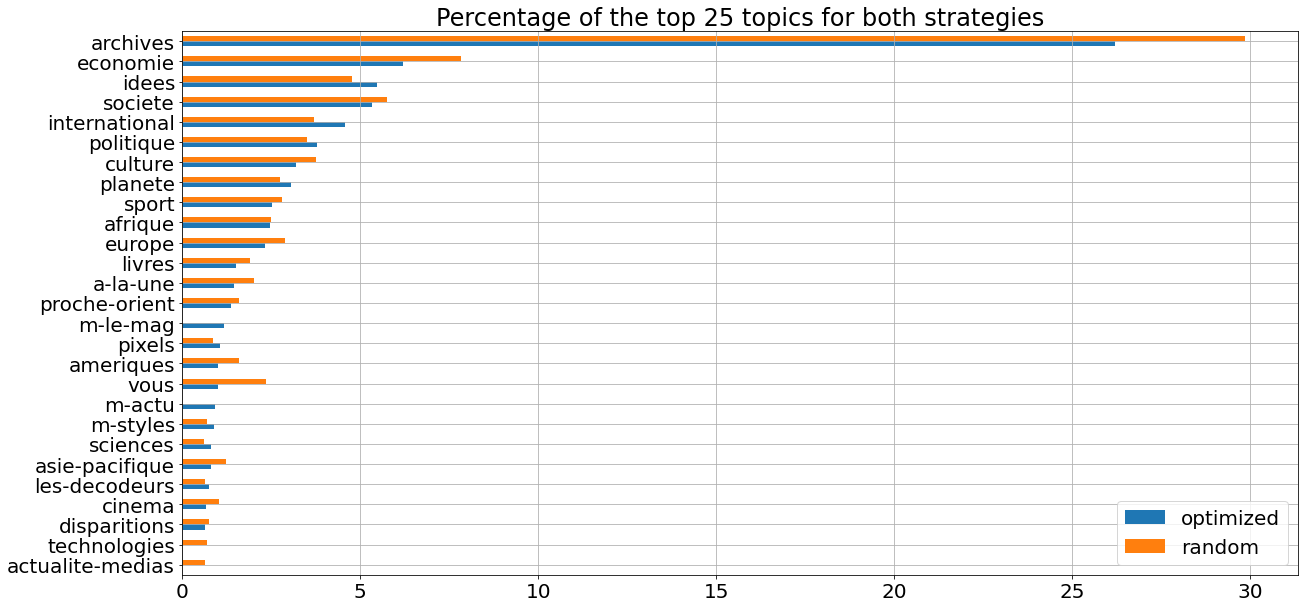

In [69]:
mixed_topics = {"optimized": record_items_meta_topics_df_means.iloc[-25:],
                "random": normal_topics_distribtion_df_means.iloc[-25:]}
# mixed_topics = {"optimized": record_items_meta_topics_df_means,
#                 "random": normal_topics_distribtion_df_means}
mixed_topics = 100 * pd.DataFrame.from_dict(mixed_topics).fillna(
    0).sort_values(by=['optimized'], ascending=True) / 500
plt.figure()
mixed_topics.plot.barh(figsize=(20, 10), grid=True)
plt.title("Percentage of the top 25 topics for both strategies")
plt.savefig("top_25_topics_means.png")
# mixed_topics_ranking = mixed_topics.rank(axis=0, ascending=True)
# np.abs(mixed_topics_ranking['optimized'] -
    #    mixed_topics_ranking['random']).sort_values()
# mixed_topics_ranking.plot.barh(figsize=(20, 10))
mixed_topics


archives             0.0
sport                0.0
a-la-une             0.0
economie             0.0
les-decodeurs        0.5
idees                1.0
societe              1.0
international        1.0
politique            1.0
afrique              1.0
proche-orient        1.0
m-styles             1.0
ameriques            1.5
livres               2.0
planete              2.0
culture              2.0
pixels               3.0
europe               3.0
actualite-medias     3.0
sciences             4.0
technologies         4.5
asie-pacifique       5.0
disparitions         5.0
vous                 5.5
cinema               6.0
m-actu               7.5
m-le-mag            11.5
dtype: float64

<Figure size 432x288 with 0 Axes>

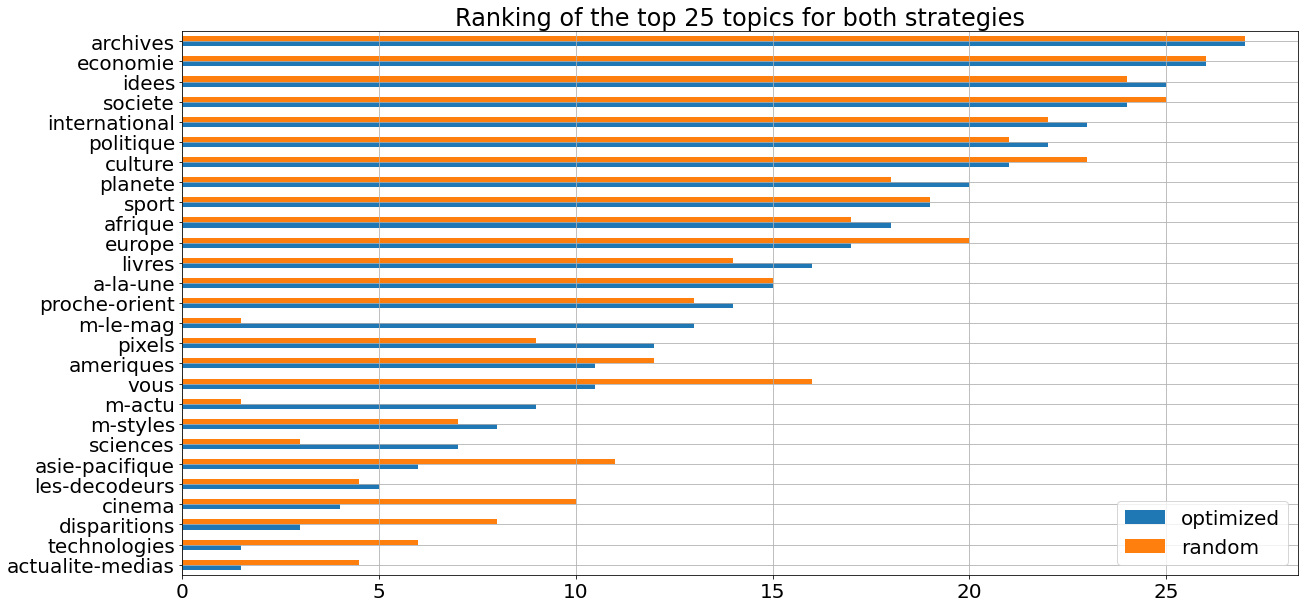

In [70]:
mixed_topics = {"optimized": record_items_meta_topics_df_means.iloc[-25:],
                "random": normal_topics_distribtion_df_means.iloc[-25:]}
# mixed_topics = {"optimized": record_items_meta_topics_df_means,
#                 "random": normal_topics_distribtion_df_means}
mixed_topics = 100 * pd.DataFrame.from_dict(mixed_topics).fillna(0).sort_values(by=['optimized'], ascending=True) / 500
mixed_topics_ranking = mixed_topics.rank(axis=0, ascending=True)
plt.figure()
mixed_topics_ranking.plot.barh(figsize=(20, 10), grid=True)
plt.title("Ranking of the top 25 topics for both strategies")
plt.savefig("top_25_topics_ranking.png")
np.abs(mixed_topics_ranking['optimized'] - mixed_topics_ranking['random']).sort_values()
# mixed_topics_ranking.plot.barh(figsize=(20, 10))


In [63]:
normal_topics_distribtion_df_t = normal_topics_distribtion_df.T / 500
record_items_meta_topics_df_t = record_items_meta_topics_df.T / 500

# normal_topics_distribtion_df_t / 500
topics_signficance = {}
for topic in set(list(normal_topics_distribtion_df_top_20.index) + list(record_items_meta_topics_df_top_20.index)):
    significance = scipy.stats.wilcoxon(
        normal_topics_distribtion_df_t[topic], record_items_meta_topics_df_t[topic])

    topics_signficance[topic] = {
        'p-value': significance.pvalue
    }

    if significance.pvalue < 0.05:
        print(
            f"{topic} :: {significance} -- normal: {normal_topics_distribtion_df_t[topic].mean()} -- optimized: {record_items_meta_topics_df_t[topic].mean()}")
        topics_signficance[topic]['is_significant'] = True
    else:
        topics_signficance[topic]['is_significant'] = False

pd.DataFrame.from_dict(topics_signficance).to_csv('topics_signficance.csv')


economie :: WilcoxonResult(statistic=62.0, pvalue=7.5903645460742985e-06) -- normal: 0.07825 -- optimized: 0.06194999999999999
europe :: WilcoxonResult(statistic=124.0, pvalue=0.0005920950707355363) -- normal: 0.0289 -- optimized: 0.0232
m-styles :: WilcoxonResult(statistic=171.0, pvalue=0.028971321322309545) -- normal: 0.0071 -- optimized: 0.009
m-actu :: WilcoxonResult(statistic=2.5, pvalue=1.2764337379956673e-07) -- normal: 0.0019000000000000002 -- optimized: 0.00935
international :: WilcoxonResult(statistic=121.5, pvalue=0.00017765874673535486) -- normal: 0.03705 -- optimized: 0.045799999999999993
a-la-une :: WilcoxonResult(statistic=135.0, pvalue=0.001079211873524129) -- normal: 0.020249999999999997 -- optimized: 0.014499999999999999
pixels :: WilcoxonResult(statistic=153.5, pvalue=0.0377660259804368) -- normal: 0.008549999999999999 -- optimized: 0.01055
archives :: WilcoxonResult(statistic=69.5, pvalue=4.7118026056674895e-06) -- normal: 0.29845 -- optimized: 0.26189999999999997
a